In [1]:
#library imports
import os
import pandas as pd
import numpy as np

import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as T


from tqdm import tqdm

In [2]:
def rgb2gray(rgb: torch.Tensor):
    r, g, b = rgb[0,:,:], rgb[1,:,:], rgb[2,:,:]
    gray = r + g + b
    gray = gray.to(dtype=torch.float32)
    gray = gray/(torch.max(gray)*2)

    return gray

In [3]:
blurrer = T.GaussianBlur(kernel_size=(3, 3))

In [4]:
def get_edges(image, blurrer, conv_X, conv_Y, save = False, image_name = ''):
    blurred_img = blurrer(image)
    grayscale_img_T = rgb2gray(blurred_img).unsqueeze(0)
    g = torch.hypot(conv_X(grayscale_img_T), conv_Y(grayscale_img_T))
    g_img_T = (g.squeeze(0) > 0.45).to(dtype=g.dtype)
    if save:
        g_img = T.ToPILImage()(g_img_T)
        g_img.save(f'edge_detection/{image_name}')
    return g_img_T

In [5]:
Prewitt_X = torch.tensor(
    [[1, 0, -1],
     [1, 0, -1], 
     [1, 0, -1]], dtype=torch.float32)
Prewitt_X = Prewitt_X.unsqueeze(0).unsqueeze(0)

Prewitt_Y = torch.tensor(
    [[1, 1, 1],
     [0, 0, 0], 
     [-1, -1, -1]], dtype=torch.float32)
Prewitt_Y = Prewitt_Y.unsqueeze(0).unsqueeze(0)

In [6]:
conv_X = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
conv_Y = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

In [7]:
conv_X.weight = nn.Parameter(Prewitt_X)
conv_Y.weight = nn.Parameter(Prewitt_Y)

In [8]:
# n = 0
# images = torch.zeros((100, 778, 1818))
# for image_name in os.listdir("images/"):
#     if image_name.endswith(".png"):
#         image = Image.open(f'images/{image_name}')
#         image = T.PILToTensor()(image)
#         images[n] = get_edges(image, blurrer, conv_X, conv_Y, True, f'{image_name}')
#         n = n+1
# print(f"{n} done!!!")

In [9]:
labels_list = []

n = 0
for label_name in os.listdir("labels/"):
    if label_name.endswith(".xml"):
        anno = {}
        tree = ET.parse(f'labels/{label_name}')
        root = tree.getroot()
        n+=1
        anno['filename'] = 'images/' + label_name.replace('xml', 'png')
        anno['xmin'] = int(root[6][4][0].text)/1820
        anno['ymin'] = int(root[6][4][1].text)/780
        anno['xmax'] = int(root[6][4][2].text)/1820
        anno['ymax'] = int(root[6][4][3].text)/780
        # print(label_name, str(n) + '.png', int(root[6][4][0].text))
        
        labels_list.append(anno)

labels: pd.DataFrame = pd.DataFrame(labels_list)

In [10]:
labels.head()

,filename,xmin,ymin,xmax,ymax
0,images/1.png,0.277473,0.597436,0.402198,0.880769
1,images/10.png,0.242857,0.584615,0.358791,0.857692
2,images/100.png,0.384615,0.621795,0.525824,0.956410
3,images/11.png,0.404396,0.679487,0.539011,1.000000
4,images/12.png,0.421429,0.648718,0.549451,0.953846


In [11]:
max_x = 0
max_y = 0

for _, x in labels.iterrows():
    if x[3]- x[1] > max_x:
        max_x = x[3] - x[1]
    if x[4]- x[2] > max_x:
        max_y = x[4] - x[2]

print(max_x, max_y)

0.1412087912087912 0.2833333333333333


In [12]:
#Reading an image
def read_image(path):
    image = Image.open(path)
    image = T.PILToTensor()(image)
    return image

In [13]:
def denormalize(bb):
    return (bb*[780, 1820, 780, 1820]).astype(np.int64)

def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    # print(bb)
    Y = np.zeros((rows, cols))
    bb = denormalize(bb.astype(np.float64))
    # print(bb)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[1],x[0],x[3],x[2]])

In [14]:
im = cv2.imread(str(labels.values[58][0]))
bb = create_bb_array(labels.values[58][1:])
print(im.shape)
print(str(labels.values[58]))

(780, 1820, 3)
['images/61.png' 0.3901098901098901 0.5217948717948718 0.49615384615384617
 0.7743589743589744]


In [15]:
print(bb)
Y = create_mask(bb, im)
mask_to_bb(Y)

[0.52179487 0.39010989 0.77435897 0.49615385]


array([407., 710., 603., 902.], dtype=float32)

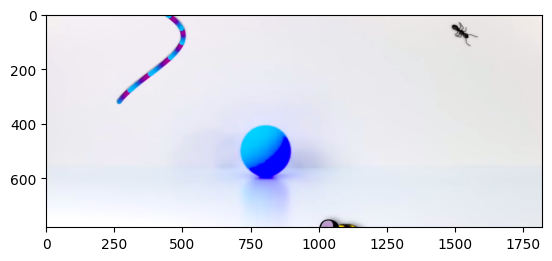

In [16]:
plt.imshow(im)

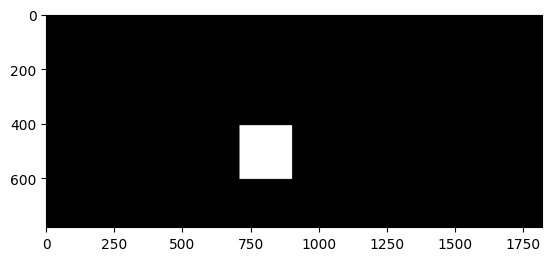

In [17]:
plt.imshow(Y, cmap='gray')

In [18]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=1)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

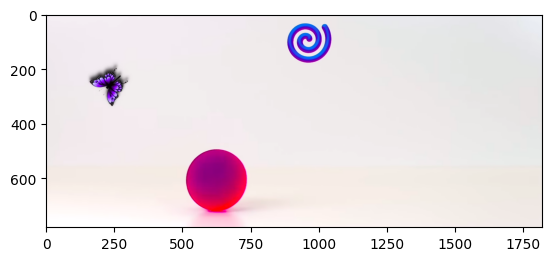

In [19]:
#original
im = cv2.imread(str(labels.values[68][0]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, create_bb_array(denormalize(labels.values[68][1:])))

In [20]:
bbs = []
for index, row in labels.iterrows():
    # print(row.values)
    bb = create_bb_array(row.values[1:])
    bbs.append(bb)
labels['bb'] = bbs
labels.head()

,filename,xmin,ymin,xmax,ymax,bb
0,images/1.png,0.277473,0.597436,0.402198,0.880769,"[0.5974358974358974, 0.2774725274725275, 0.880..."
1,images/10.png,0.242857,0.584615,0.358791,0.857692,"[0.5846153846153846, 0.24285714285714285, 0.85..."
2,images/100.png,0.384615,0.621795,0.525824,0.956410,"[0.6217948717948718, 0.38461538461538464, 0.95..."
3,images/11.png,0.404396,0.679487,0.539011,1.000000,"[0.6794871794871795, 0.4043956043956044, 1.0, ..."
4,images/12.png,0.421429,0.648718,0.549451,0.953846,"[0.6487179487179487, 0.42142857142857143, 0.95..."


In [21]:
df_train = labels.reset_index()

In [22]:
X = df_train['filename']
Y = df_train['bb']

In [23]:
X.head()

0      images/1.png
1     images/10.png
2    images/100.png
3     images/11.png
4     images/12.png
Name: filename, dtype: object

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [25]:
class CirclesDataset(Dataset):
    def __init__(self, paths, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.y = y.values

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_bb = self.y[idx]
        x = read_image(path)
        x = get_edges(x, blurrer, conv_X, conv_Y)
        x = torch.roll(x, 2)
        return x, y_bb

In [26]:
train_ds = CirclesDataset(X_train ,y_train)
valid_ds = CirclesDataset(X_val, y_val)

In [27]:
train_ds.paths

array(['images/59.png', 'images/89.png', 'images/32.png', 'images/47.png',
       'images/71.png', 'images/22.png', 'images/45.png', 'images/96.png',
       'images/17.png', 'images/74.png', 'images/19.png', 'images/51.png',
       'images/86.png', 'images/34.png', 'images/93.png', 'images/13.png',
       'images/69.png', 'images/68.png', 'images/40.png', 'images/23.png',
       'images/53.png', 'images/4.png', 'images/15.png', 'images/95.png',
       'images/33.png', 'images/26.png', 'images/82.png', 'images/31.png',
       'images/65.png', 'images/20.png', 'images/30.png', 'images/11.png',
       'images/24.png', 'images/43.png', 'images/16.png', 'images/8.png',
       'images/14.png', 'images/67.png', 'images/41.png', 'images/9.png',
       'images/6.png', 'images/99.png', 'images/58.png', 'images/48.png',
       'images/54.png', 'images/7.png', 'images/50.png', 'images/70.png',
       'images/64.png', 'images/97.png', 'images/80.png', 'images/46.png',
       'images/61.png', 'image

In [28]:
batch_size = 1
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [29]:
X_train.shape

(80,)

In [54]:
# class BB_model(nn.Module):
#     def __init__(self):
#         super(BB_model, self).__init__()
#         resnet = models.resnet34(pretrained=True)
#         layers = list(resnet.children())[:8]
#         self.features1 = nn.Sequential(*layers[:6])
#         self.features2 = nn.Sequential(*layers[6:])
#         self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
#         self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
#     def forward(self, x):
#         x = self.features1(x)
#         x = self.features2(x)
#         x = F.relu(x)
#         x = nn.AdaptiveAvgPool2d((1,1))(x)
#         x = x.view(x.shape[0], -1)
#         return self.classifier(x), self.bb(x)

class Circle_model(torch.nn.Module):

    def __init__(self):
        super(Circle_model, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(1, 6, 250)
        self.conv2 = torch.nn.Conv2d(6, 1, 200)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(9344  , 1000)
        self.fc2 = torch.nn.Linear(1000, 1000)
        self.fc3 = torch.nn.Linear(1000, 512)
        self.fc4 = torch.nn.Linear(512, 4)



    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # If the size is a square you can only specify a single number
        x = x.view(-1, self.num_flat_features(x))
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [55]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [56]:
import torchvision
def val_metrics(model, valid_dl, C=1):
    model.eval()
    total = 0
    sum_loss = 0
    for id, (x, y_bb) in enumerate(valid_dl):
        x = x.cuda().float()
        y_bb = y_bb.cuda().float()
        out_bb = model(x)
        # loss_bb = torchvision.ops.distance_box_iou_loss(out_bb, y_bb)
        loss_bb = F.mse_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_bb/C
        sum_loss += loss.item()
        total += 1
    return sum_loss/total

In [57]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1):
    idx = 0
    for i in range(epochs):
        model.train()
        total: int = 0
        sum_loss = 0
        for (x, y_bb) in tqdm(train_dl, desc=f"Epoch: {i+1}"):
            x = x.cuda().float()
            y_bb = y_bb.cuda().float()
            out_bb = model(x)
            # loss_bb = torchvision.ops.distance_box_iou_loss(out_bb, y_bb)
            loss_bb = F.mse_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += 1
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss = val_metrics(model, val_dl, C)
        print("Train loss: %.4f\nVal loss: %.4f" % (train_loss, val_loss))
    return sum_loss/total

In [58]:
model = Circle_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.00001)

In [59]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

Epoch: 1: 100%|██████████| 80/80 [04:51<00:00,  3.65s/it]


Train loss: 0.2753
Val loss: 0.0788


Epoch: 2: 100%|██████████| 80/80 [04:51<00:00,  3.65s/it]


Train loss: 0.0647
Val loss: 0.0632


Epoch: 3: 100%|██████████| 80/80 [04:51<00:00,  3.65s/it]


Train loss: 0.0451
Val loss: 0.0537


Epoch: 4: 100%|██████████| 80/80 [04:51<00:00,  3.65s/it]


Train loss: 0.0327
Val loss: 0.0380


Epoch: 5: 100%|██████████| 80/80 [04:51<00:00,  3.65s/it]


Train loss: 0.0245
Val loss: 0.0302


Epoch: 6: 100%|██████████| 80/80 [04:51<00:00,  3.65s/it]


Train loss: 0.0199
Val loss: 0.0261


Epoch: 7: 100%|██████████| 80/80 [04:51<00:00,  3.64s/it]


Train loss: 0.0174
Val loss: 0.0260


Epoch: 8: 100%|██████████| 80/80 [04:51<00:00,  3.64s/it]


Train loss: 0.0148
Val loss: 0.0248


Epoch: 9: 100%|██████████| 80/80 [04:51<00:00,  3.64s/it]


Train loss: 0.0136
Val loss: 0.0215


Epoch: 10: 100%|██████████| 80/80 [04:51<00:00,  3.64s/it]


Train loss: 0.0127
Val loss: 0.0230


Epoch: 11: 100%|██████████| 80/80 [04:51<00:00,  3.64s/it]


Train loss: 0.0122
Val loss: 0.0202


Epoch: 12: 100%|██████████| 80/80 [04:51<00:00,  3.64s/it]


Train loss: 0.0110
Val loss: 0.0239


Epoch: 13: 100%|██████████| 80/80 [04:51<00:00,  3.64s/it]


Train loss: 0.0105
Val loss: 0.0168


Epoch: 14: 100%|██████████| 80/80 [04:51<00:00,  3.64s/it]


Train loss: 0.0099
Val loss: 0.0168


Epoch: 15: 100%|██████████| 80/80 [04:51<00:00,  3.64s/it]


Train loss: 0.0095
Val loss: 0.0155


0.009524595071843578

In [60]:
torch.save(model.state_dict(), 'model.pth')

In [61]:
update_optimizer(optimizer, 0.0001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

Epoch: 1: 100%|██████████| 80/80 [04:49<00:00,  3.61s/it]


Train loss: 0.0343
Val loss: 0.0864


Epoch: 2: 100%|██████████| 80/80 [04:50<00:00,  3.63s/it]


Train loss: 0.0380
Val loss: 0.0223


Epoch: 3: 100%|██████████| 80/80 [04:49<00:00,  3.62s/it]


Train loss: 0.0188
Val loss: 0.0195


Epoch: 4: 100%|██████████| 80/80 [04:49<00:00,  3.62s/it]


Train loss: 0.0137
Val loss: 0.0244


Epoch: 5: 100%|██████████| 80/80 [04:50<00:00,  3.63s/it]


Train loss: 0.0127
Val loss: 0.0175


Epoch: 6: 100%|██████████| 80/80 [04:49<00:00,  3.62s/it]


Train loss: 0.0217
Val loss: 0.0462


Epoch: 7: 100%|██████████| 80/80 [04:49<00:00,  3.62s/it]


Train loss: 0.0256
Val loss: 0.0275


Epoch: 8: 100%|██████████| 80/80 [04:49<00:00,  3.62s/it]


Train loss: 0.0136
Val loss: 0.0234


Epoch: 9: 100%|██████████| 80/80 [04:49<00:00,  3.62s/it]


Train loss: 0.0122
Val loss: 0.0224


Epoch: 10: 100%|██████████| 80/80 [04:49<00:00,  3.62s/it]


Train loss: 0.0094
Val loss: 0.0164


0.009357909659138386

In [62]:
torch.save(model.state_dict(), 'model.pth')

In [63]:
# test Dataset
test_ds = CirclesDataset(pd.DataFrame([{'path':'./images/78.png'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'])
x, y_bb = test_ds[0]
xx = x[None,].cuda().float()
# prediction
out_bb = model(xx)
# predicted bounding box
bb_hat = denormalize(out_bb.detach().cpu().numpy())
print(bb_hat[0])
bb_hat = bb_hat[0].tolist()
img = Image.open('./images/78.png')
draw = ImageDraw.Draw(img)
draw.rectangle((bb_hat[1], bb_hat[0], bb_hat[3], bb_hat[2]), outline="green", width = 2)

img.save('78.png')

[395 483 615 707]


In [64]:
n = 0
for image_name in os.listdir("images/"):
    if image_name.endswith(".png"):
        test_ds = CirclesDataset(pd.DataFrame([{'path':str('images/' + image_name)}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'])
        x, y_bb = test_ds[0]
        xx = x[None,].cuda().float()
        # prediction
        # print(xx)
        out_bb = model(xx)
        # print(out_bb)
        # predicted bounding box
        bb_hat = out_bb.detach().cpu().numpy()
        bb_hat = denormalize(bb_hat)
        bb_hat = bb_hat.astype(int)
        bb_hat = bb_hat[0].tolist()
        n += 1
        print(n, bb_hat)
        img = Image.open(f'./images/{image_name}')
        draw = ImageDraw.Draw(img)
        draw.rectangle((bb_hat[1], bb_hat[0], bb_hat[3], bb_hat[2]), outline="green", width = 2)

        img.save(f'./output/{image_name}')

1 [460, 496, 683, 723]
2 [475, 380, 700, 608]
3 [484, 644, 712, 889]
4 [498, 664, 733, 912]
5 [509, 702, 742, 960]
6 [528, 1199, 760, 1441]
7 [483, 1435, 715, 1669]
8 [531, 1226, 764, 1470]
9 [516, 970, 746, 1214]
10 [514, 720, 745, 978]
11 [482, 318, 705, 546]
12 [434, 401, 655, 626]
13 [475, 194, 698, 421]
14 [480, 234, 703, 460]
15 [521, 1157, 754, 1399]
16 [479, 1422, 709, 1656]
17 [505, 806, 735, 1052]
18 [480, 676, 711, 920]
19 [478, 487, 705, 721]
20 [526, 1186, 760, 1429]
21 [505, 852, 736, 1101]
22 [516, 820, 749, 1069]
23 [462, 556, 688, 795]
24 [497, 1032, 727, 1271]
25 [512, 1144, 743, 1383]
26 [509, 689, 741, 944]
27 [494, 670, 727, 917]
28 [464, 725, 693, 960]
29 [499, 940, 729, 1178]
30 [509, 1135, 741, 1374]
31 [506, 1009, 736, 1249]
32 [487, 532, 712, 765]
33 [508, 1032, 740, 1272]
34 [510, 1007, 740, 1246]
35 [477, 1424, 707, 1657]
36 [471, 639, 699, 883]
37 [495, 1060, 724, 1295]
38 [493, 1046, 721, 1281]
39 [530, 1227, 761, 1471]
40 [455, 351, 673, 559]
41 [470, 190

In [ ]:
# for x in range(labels.shape[0]):
#     bb_hat = labels.iloc[x]
#     img = Image.open(f'./{bb_hat[0]}')
#     draw = ImageDraw.Draw(img)
#     draw.rectangle((bb_hat[1], bb_hat[2], bb_hat[3], bb_hat[4]), outline="red", width = 2)

#     img.save(f'./output/{bb_hat[0][6:]}')

In [ ]:
# image_name = '78.png'
# test_ds = CirclesDataset(pd.DataFrame([{'path':str('images/' + image_name)}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'])
# x, y_bb = test_ds[0]
# xx = torch.FloatTensor(x[None,]).cuda()
#         # prediction
# out_bb = model(xx)
# # predicted bounding box
# bb_hat = out_bb.detach().cpu().numpy()
# bb_hat = denormalize(bb_hat)
# bb_hat = bb_hat.astype(int)
# bb_hat = bb_hat[0].tolist()
# img = Image.open(f'./images/{image_name}')
# draw = ImageDraw.Draw(img)
# draw.rectangle((bb_hat[1], bb_hat[0], bb_hat[3], bb_hat[2]), outline="green", width = 2)

# img.save(f'{image_name}')
# (T.ToPILImage()(x)).save(f'{image_name}_edge.png')